# Extract pole-like street furniture

In this notebook we demonstrate how we can extract pole-like objects form labeled point clouds.

In this code we assume the point clouds have been labelled following the process in our [Urban PointCloud Processing](https://github.com/Amsterdam-AI-Team/Urban_PointCloud_Processing/tree/main/datasets) project. For more information on the specifics of the datasets used, see [the description there](https://github.com/Amsterdam-AI-Team/Urban_PointCloud_Processing/blob/main/datasets/README.md).

In [1]:
# Add project src to path.
import set_path

import numpy as np
import pandas as pd
import os
import pathlib
import laspy
from tqdm import tqdm

from upcp.labels import Labels
from upcp.utils import las_utils
from upcp.utils import ahn_utils

from upc_analysis import PoleExtractor
from upc_analysis import visualization

QSocketNotifier: Can only be used with threads started with QThread


In [2]:
# We provide some example data for demonstration purposes.
dataset_folder = '../datasets/pointcloud/'
prefix = 'processed_'
files = list(pathlib.Path(dataset_folder).glob(f'{prefix}*.laz'))

# Define the class we are interested in, e.g. STREET_LIGHT, TRAFFIC_SIGN.
target_label = Labels.STREET_LIGHT

# AHN data reader for elevation data. This is optional: the data is only used when
# the ground elevation cannot be determined from the labeled point cloud itself.
ahn_data_folder = '../datasets/ahn/'
ahn_reader = ahn_utils.NPZReader(ahn_data_folder, caching=False)

# BGT data reader for building shapes. This is optional: the data is used to check
# whether an extracted object is located within a building footprint. This might
# indicate a false positive.
# If an appropriate dataset is available, uncomment these lines to use it:
if os.path.exists('../datasets/bgt/bgt_buildings_demo.csv'):
    bgt_building_file = '../datasets/bgt/bgt_buildings_demo.csv'
    bld_reader = bgt_utils.BGTPolyReader(bgt_building_file, building_offset=0)
else:
    bld_reader = None

---
## Extracting pole-like objects

This method works by clustering points of a given target class, and then using statistics and PCA analysis on each cluster to determine the exact pole.

The result is a dataset with the following features for each extracted object:
```txt
rd_x, rd_y, z = X, Y, Z coordinates of the base of the pole
tx, ty, tz    = X, Y, Z coordinates of the top of the pole
height        = the height of the pole, in m
angle         = the angle of the pole, in degrees w.r.t. vertical
prob          = the average probability of the classification, if this data is available in the point cloud
n_points      = the number of points of the object
in_bld        = flag that indicates whether the object is located inside a building footprint
debug         = debug code, see below
tilecode      = tilecode in which the object was found
```
The debug code `A_B` indicates potential issues with either the ground elevation (A) or the pole extraction (B). A can be either 0 (no problems), 1 (no ground elevation found in the point cloud), or 2 (no ground elevation found in AHN). B can be either 0 (no problems), 3 (not enough data to determine the angle), or 4 (not enough data to determine the exact location).

In [3]:
# Labels used for ground points.
ground_labels = [Labels.GROUND, Labels.ROAD]

# Create PoleExtractor object.
pole_extractor = PoleExtractor(target_label, ground_labels,
                               ahn_reader=ahn_reader, building_reader=bld_reader,
                               min_component_size=100, octree_grid_size=0.4)

# Loop over point cloud files and extract objects.
locations = []
for file in tqdm(files):
    tilecode = las_utils.get_tilecode_from_filename(file.as_posix())
    pc = laspy.read(file)
    labels = pc.label
    if 'probability' in pc.point_format.extra_dimension_names:
        probabilities = pc.probability
    else:
        probabilities = np.zeros_like(labels)

    if np.count_nonzero(labels == target_label) > 0:
        points = np.vstack((pc.x, pc.y, pc.z)).T
        tile_locations = pole_extractor.get_pole_locations(points, labels, probabilities, tilecode)
        locations.extend([(*x, tilecode) for x in tile_locations])

HEADERS = ['rd_x', 'rd_y', 'z', 'tx', 'ty', 'tz', 'height', 'angle', 'prob', 'n_points', 'in_bld', 'debug', 'tilecode']
poles_df = pd.DataFrame(locations, columns=HEADERS)

100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.99s/it]


In [4]:
poles_df

,rd_x,rd_y,z,tx,ty,tz,height,angle,prob,n_points,in_bld,debug,tilecode
0,119325.25,485103.27,0.38,119325.19,485103.37,7.60,7.22,0.91,0.0,5730,0,0_0,2386_9702
1,119313.05,485104.17,0.51,119312.87,485104.22,7.82,7.31,1.43,0.0,4482,0,0_0,2386_9702
2,119341.53,485113.85,0.41,119341.62,485113.82,7.60,7.19,0.72,0.0,4476,0,0_0,2386_9702
3,119338.62,485122.56,0.56,119338.81,485122.55,7.75,7.19,1.53,0.0,5974,0,0_0,2386_9702
4,119318.87,485146.92,0.20,119318.83,485146.94,5.30,5.11,0.55,0.0,3717,0,0_0,2386_9702
5,119896.66,485255.75,0.35,119896.44,485255.78,6.91,6.56,1.96,0.0,11494,0,0_0,2397_9705
6,119891.84,485267.01,0.46,119891.73,485266.99,7.01,6.55,0.98,0.0,17340,0,0_0,2397_9705
7,119876.82,485287.90,0.65,119876.81,485287.87,7.23,6.58,0.32,0.0,17632,0,0_0,2397_9705
8,119894.37,485287.05,0.72,119894.26,485287.37,7.05,6.34,3.05,0.0,4766,0,0_0,2397_9705
9,119866.94,485289.82,0.43,119867.14,485290.16,6.91,6.49,3.52,0.0,26330,0,0_0,2397_9705


In [5]:
# Optional: save the data in CSV format.
poles_df.to_csv('../datasets/poles_extracted.csv', index=False)

---
## Visualize extracted poles

In order to verify the results and spot potential issues, we can visualize individual objects. The visualization renders the object from two directions (X and Y axis), along with a 3D projection.

In [6]:
# Optional: load data from CSV.
poles_df = pd.read_csv('../datasets/poles_extracted.csv')

In [7]:
# Either choose a row number of sample one randomly.
row_id = 2
# idx = np.random.randint(0, len(poles_df))
# row_id = poles_df.index[idx]

# Get the object features.
obj = poles_df.loc[row_id]
obj_location = (obj.rd_x, obj.rd_y, obj.z)
obj_top = (obj.tx, obj.ty, obj.tz)

# Let's see the object in question.
poles_df.loc[[row_id]]

,rd_x,rd_y,z,tx,ty,tz,height,angle,prob,n_points,in_bld,debug,tilecode
2,119341.53,485113.85,0.41,119341.62,485113.82,7.6,7.19,0.72,0.0,4476,0,0_0,2386_9702


In [8]:
# Load the point cloud data for the tile containing this object.
cloud = laspy.read(f'{dataset_folder}{prefix}{obj.tilecode}.laz')
points = np.vstack((cloud.x, cloud.y, cloud.z)).T
labels = cloud.label
colors = np.vstack((cloud.red, cloud.green, cloud.blue)).T / (2**16 - 1)

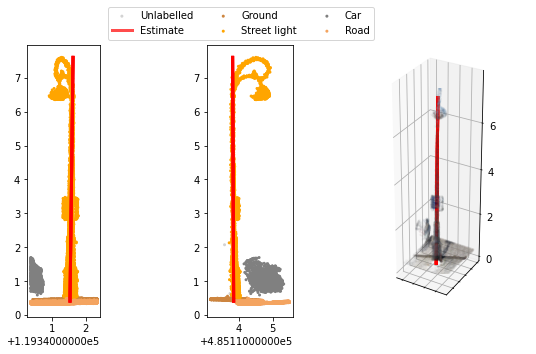

In [9]:
%matplotlib inline

# Get a mask for the point cloud around the object's location.
obj_mask = visualization.get_mask_for_obj(points, labels, target_label, obj_location, obj_top[2],
                                          obj_angle=obj.angle, min_component_size=100,
                                          octree_grid_size=0.4, noise_filter=True)

# Show the object.
visualization.plot_object(points[obj_mask], labels[obj_mask], colors=colors[obj_mask],
                          estimate=np.vstack((obj_location, obj_top)))